# Introduction

This notebook details the extraction of additional relevant entities and relationships from the DOCLEG database to enrich the base document graph. The extraction is automated using LLMs and focuses on two main elements:

- _Legal Concepts_: Identifying legally relevant concepts within the document texts. These concepts are added as new nodes in the graph, with edges linking them to the texts where they appear, thereby interconnecting different sub-graphs within the overall document graph.

- _Document References_: Detecting references to other legal documents within the texts. These references are incorporated as new edges, connecting texts that mention other documents.

The primary motivation for adding these entities is to enhance the graph’s ability to represent the comprehensive information contained in the DOCLEG database, ultimately facilitating more accurate and robust responses to user queries.

## 0. Import dependencies

In [1]:
# Standard library imports
import os
import pickle
import random
import sys

# Third party imports
import pandas as pd
from dotenv import load_dotenv
from openai import AzureOpenAI
from pydantic import BaseModel
from tqdm import tqdm
from collections import defaultdict

# Determine the project root directory for relative imports
try:
    # This will work in scripts where __file__ is defined
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Assuming "src" is parallel to the script folder
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
except NameError:
    # In notebooks __file__ is not defined: assume we're in notebooks/riziv_dataset/
    project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from riziv.riziv_structured_output_schemas import ConceptExtraction, CitationExtraction

## 1. Loading the data

In [2]:
# Define the path to the RIZIV dataset files
RIZIV_data_path = os.path.join(project_root, "data", "RIZIV_hackathon_main")

# Load the base document graph
with open(os.path.join(RIZIV_data_path,'base_document_graph.pkl'), 'rb') as f:
    G = pickle.load(f)

# Load the chunks DataFrame from CSV
chunks_df = pd.read_csv(os.path.join(RIZIV_data_path, 'df_sequence_text_chunks.csv'))

# Resolve .env path relative to this notebook
env_path = os.path.join(RIZIV_data_path, '.env')

# Load environment variables from the .env file
load_dotenv(dotenv_path=env_path)

True

## 2. Extraction of legal concepts

For the extraction of relevant concepts an LLM was employed to sequentially analyze the texts within the based document graph and extract at most 10 relevant legal concepts from each one. Alongside the concepts themselves, the LLM is also instructed to return a category within a pre-defined list of categories for each relevant concept (see prompt template in code below) as well as a relevance score  to proxy the global relevance of each extracted concept within its text fragment as perceived by the LLM. The category is meant to be employed during the filtering and pre-processing of the relevant terms prior to their inclusion in the document graph as new nodes. Meanwhile, the relevance score is included in the output for similar reasons as well as an attempt to further steer the LLM's behaviour into including only concepts which appear to be globally relevant within a provided text fragment and minimize the appearence of "noisy concepts".

Due to the time constrains faced during the hackathon, the extension of the DOCLEG database, and the potential computational and monetary costs associated with employing the presented approach at scale, extraction of legal concepts was only conducted over a sample of 3% of all text chunks within the base document graph. Applied at this level, the inclussion of these relevant legal concepts in the base document graph has a merely illustrative impact and is considered to have a negligible influence at the time of improving the quality of answers to the user's queries. The different constraints of the hackathon format prevented a further extension and refinement of this apporach which could lead to the realization of its proposed advantages.

Following the flow of the code presented below, after the final dictionary of relevant legal concepts was extracted, it is converted into a DataFrame and stored to be used in subsequent notebooks to add these to the base document graph.

In [3]:
########################################################################################
# Extraction of relevant legal concepts
########################################################################################

# Note (1): For testing purposes, the sample size was set to 0.03% of the total number of chunks in the 
# base document graph instead of the original 3% employed during the hackathon.

# Note (2): All code segments related to tracking the costs of the API calls have been commented/disabled

# Instantiate Azure OpenAI client
client = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

# Dictionary to store all results
all_concepts = {}

# Note: All code segments related to tracking the costs of the API calls have been commented/disabled

## Counters for tokens and cost
#total_prompt_tokens = 0
#total_completion_tokens = 0
#total_cost = 0

# Get list of chunk nodes from the graph
chunk_nodes = [node for node in G.nodes() if G.nodes[node].get('type_node') == 'text_chunk']
total_chunks = len(chunk_nodes)
print(f"Found {total_chunks} chunks in total")

# Calculate 0.03% sample size and get random sample
sample_size = int(total_chunks * 0.0003)
sampled_chunks = random.sample(chunk_nodes, sample_size)
print(f"Processing {sample_size} chunks ({0.03}% of total)")

# Iterate over sampled chunks with progress bar
for idx, chunk_id in enumerate(tqdm(sampled_chunks, desc="Processing chunks")):
    # Get text from chunk
    chunk_text = G.nodes[chunk_id]['text']
    
    try:
        # Call API for concept extraction
        completion = client.beta.chat.completions.parse(
            model=os.getenv("AZURE_OPENAI_DEPLOYMENT"), 
            messages=[
                {"role": "system", "content": """You are an expert legal analyst specialized in Belgian legal texts from the RIZIV/INAMI corpus. 
                 Your task is to extract only the most relevant legal concepts from legal text fragments in French, focusing on abstract legal ideas, 
                 doctrines, and specialized terminology that are specific to the healthcare and social security domain covered by RIZIV/INAMI. 
                 You may encounter text fragments of varying length make sure to extract only the most relevant concepts
                 within the global context of the presented text. Also, assign each extracted concept one category from the following list: 
                 [Obligation, Legal Principle, Regulation, Financial Term, Administrative Process, Institution, Key Terminology, Other].
                 Do not include citations, dates, locations, or extraneous details. 

                Your output must strictly follow the JSON schema below, contain no additional commentary, and be limited to a maximum of 10 concepts, 
                 ordered from highest to lowest relevance. If no relevant legal concepts are identified, return an empty "concepts" list."""},

                {"role": "user", "content": f"""Extract the key legal concepts from the following French legal text fragment, 
                 which comes from the RIZIV/INAMI corpus. Only include legal concepts that are highly relevant and specific to healthcare 
                 legislation and social security in Belgium. Limit your output to a maximum of 10 concepts, ordered by relevance, 
                 and if there are no relevant legal concepts, return an empty "concepts" list.
                 Text: {chunk_text}"""},
            ],
            response_format=ConceptExtraction,
        )
        
        # Update token counters and calculate costs
        prompt_tokens = completion.usage.prompt_tokens
        completion_tokens = completion.usage.completion_tokens
        
        #total_prompt_tokens += prompt_tokens
        #total_completion_tokens += completion_tokens
        
        ## Calculate costs in euros
        #prompt_cost = (prompt_tokens * 1.047) / 1000000
        #completion_cost = (completion_tokens * 4.19) / 1000000
        #total_cost += prompt_cost + completion_cost
        
        # Process API response and create concept dictionary
        concepts = completion.choices[0].message.parsed
        concept_dict = {}
        
        for i in range(1, 11):
            concept_dict[i] = {
                "concept_name": getattr(concepts, f"concept{i}_name"),
                "category": getattr(concepts, f"concept{i}_category"),
                "relevance": getattr(concepts, f"concept{i}_relevance")
            }
        
        # Store in global dictionary
        all_concepts[chunk_id] = concept_dict
        
        # Print token usage and cost for this iteration
        print(f"\nIteration {idx + 1}:")
        print(f"Tokens used: {prompt_tokens} (prompt) + {completion_tokens} (completion) = {prompt_tokens + completion_tokens} total")
        #print(f"Accumulated cost: {total_cost:.6f} EUR")
        
        # Save intermediate results every 100 iterations
        if (idx + 1) % 100 == 0:
            with open(os.path.join(RIZIV_data_path, 'chunk_concepts_checkpoint.pkl'), 'wb') as f:
                pickle.dump(all_concepts, f)
            print(f"Checkpoint saved at {idx + 1} chunks")
        
    except Exception as e:
        print(f"Error processing chunk {chunk_id}: {str(e)}")
        continue

print(f"\nFinal Statistics:")
print(f"Successfully processed {len(all_concepts)} chunks")
#print(f"Total tokens used: {total_prompt_tokens} (prompt) + {total_completion_tokens} (completion) = {total_prompt_tokens + total_completion_tokens} total")
#print(f"Total cost: {total_cost:.6f} EUR")

# Save final results' dictionary to pickle file
with open(os.path.join(RIZIV_data_path, 'chunk_concepts.pkl'), 'wb') as f:
    pickle.dump(all_concepts, f)
print("Final results saved to chunk_concepts.pkl")

########################################################################################
# Converting the dictionary of concepts into a DataFrame
########################################################################################    

# Dictionary to store the concepts information
concept_info = defaultdict(lambda: {'categories': set(), 'relevances': set(), 'chunks': set()})

# Iterate through all chunks and their concepts
for chunk_id, concepts in all_concepts.items():
    for concept_dict in concepts.values():
        # Skip empty concepts (where concept_name is empty)
        if not concept_dict['concept_name']:
            continue
            
        concept_name = concept_dict['concept_name']
        concept_info[concept_name]['categories'].add(concept_dict['category'])
        concept_info[concept_name]['relevances'].add(concept_dict['relevance'])
        concept_info[concept_name]['chunks'].add(chunk_id)

# Convert to DataFrame format
df_data = []
for concept, info in concept_info.items():
    df_data.append({
        'concept_name': concept,
        'category_list': sorted(list(info['categories'])),
        'relevance_list': sorted(list(info['relevances']), reverse=True),
        'chunk_list': sorted(list(info['chunks']))
    })

# Create DataFrame
concepts_df = pd.DataFrame(df_data)

# Sort by frequency (length of chunk_list)
concepts_df['freq'] = concepts_df['chunk_list'].str.len()
concepts_df = concepts_df.sort_values('freq', ascending=False)
concepts_df = concepts_df.drop('freq', axis=1)

# Reset index for clean display
concepts_df = concepts_df.reset_index(drop=True)

print(f"Found {len(concepts_df)} unique concepts")
print("\nFirst few rows of the DataFrame:")
print(concepts_df.head())

# Save concepts DataFrame to pickle file
concepts_df.to_pickle(os.path.join(RIZIV_data_path, 'df_concepts.pkl'))

Found 43436 chunks in total
Processing 13 chunks (3% of total)


Processing chunks:   8%|▊         | 1/13 [00:17<03:35, 17.93s/it]


Iteration 1:
Tokens used: 1161 (prompt) + 2255 (completion) = 3416 total


Processing chunks:  15%|█▌        | 2/13 [00:32<02:52, 15.68s/it]


Iteration 2:
Tokens used: 1540 (prompt) + 2137 (completion) = 3677 total


Processing chunks:  23%|██▎       | 3/13 [00:36<01:46, 10.65s/it]


Iteration 3:
Tokens used: 803 (prompt) + 637 (completion) = 1440 total


Processing chunks:  31%|███       | 4/13 [00:51<01:49, 12.20s/it]


Iteration 4:
Tokens used: 1310 (prompt) + 2189 (completion) = 3499 total


Processing chunks:  38%|███▊      | 5/13 [00:59<01:25, 10.69s/it]


Iteration 5:
Tokens used: 833 (prompt) + 1149 (completion) = 1982 total


Processing chunks:  46%|████▌     | 6/13 [01:17<01:33, 13.35s/it]


Iteration 6:
Tokens used: 927 (prompt) + 2078 (completion) = 3005 total


Processing chunks:  54%|█████▍    | 7/13 [01:32<01:22, 13.77s/it]


Iteration 7:
Tokens used: 1001 (prompt) + 1902 (completion) = 2903 total


Processing chunks:  62%|██████▏   | 8/13 [01:48<01:12, 14.44s/it]


Iteration 8:
Tokens used: 1777 (prompt) + 2449 (completion) = 4226 total


Processing chunks:  69%|██████▉   | 9/13 [02:02<00:57, 14.47s/it]


Iteration 9:
Tokens used: 1687 (prompt) + 2021 (completion) = 3708 total


Processing chunks:  77%|███████▋  | 10/13 [02:16<00:42, 14.14s/it]


Iteration 10:
Tokens used: 962 (prompt) + 1931 (completion) = 2893 total


Processing chunks:  85%|████████▍ | 11/13 [02:32<00:29, 14.65s/it]


Iteration 11:
Tokens used: 949 (prompt) + 1823 (completion) = 2772 total


Processing chunks:  92%|█████████▏| 12/13 [02:40<00:12, 12.74s/it]


Iteration 12:
Tokens used: 823 (prompt) + 1112 (completion) = 1935 total


Processing chunks: 100%|██████████| 13/13 [02:56<00:00, 13.58s/it]


Iteration 13:
Tokens used: 1482 (prompt) + 2329 (completion) = 3811 total

Final Statistics:
Successfully processed 13 chunks
Final results saved to chunk_concepts.pkl
Found 67 unique concepts

First few rows of the DataFrame:
                           concept_name                       category_list  \
0                 Comité de l'assurance                       [Institution]   
1  Assurance obligatoire soins de santé  [Key Terminology, Legal Principle]   
2              Mécanisme de financement                   [Key Terminology]   
3   Intervention majorée de l'assurance                   [Key Terminology]   
4             Centre médico-pédiatrique                       [Institution]   

  relevance_list                           chunk_list  
0    [10.0, 9.0]  [chunk_12048569_0, chunk_4014131_0]  
1    [10.0, 8.0]  [chunk_12007995_0, chunk_4002207_0]  
2         [10.0]                    [chunk_4013811_0]  
3          [5.0]                    [chunk_4002207_0]  
4          [6.0] 

### 2.1 Basic exploration of the dataframe of relevant concepts

Descriptive statistics of mentions per concept:
------------------------------------------------
Minimum: 1
Maximum: 2
Mean: 1.03
Median: 1.0
Standard deviation: 0.17

Percentiles:
25%: 1.0
50%: 1.0
75%: 1.0
90%: 1.0
95%: 1.0
99%: 2.0


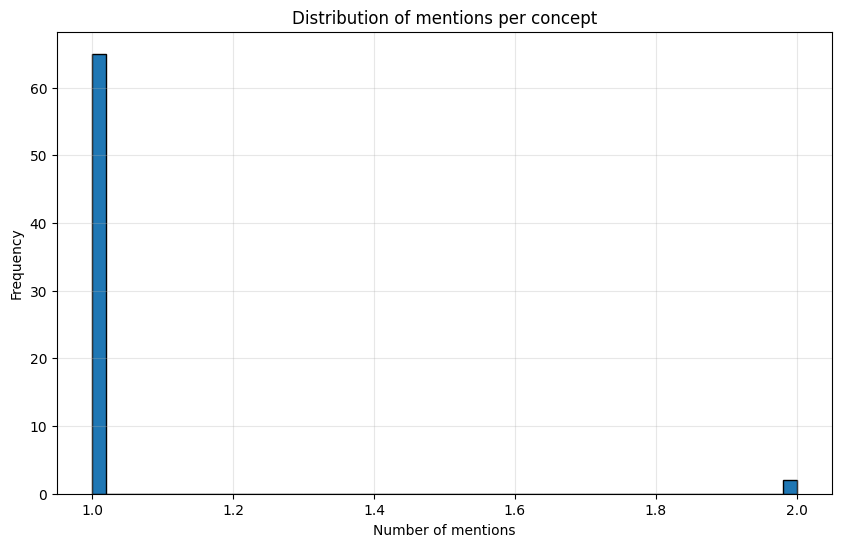


Top 10 most mentioned concepts:
--------------------------------
                                         concept_name  n_mentions
0                               Comité de l'assurance           2
1                Assurance obligatoire soins de santé           2
2                            Mécanisme de financement           1
3                 Intervention majorée de l'assurance           1
4                           Centre médico-pédiatrique           1
5   Personne à charge pour l'assurance soins de santé           1
6   Calcul de l'intervention financière (prise en ...           1
7   Calcul de l'intervention financière (prise en ...           1
8   Prescription médicale obligatoire pour prestat...           1
9   Agrément des diététiciens par le Service des s...           1
10                               Passeport du diabète           1
11  Intervention de l'assurance obligatoire soins ...           1
12  Arrêté Royal du 15 octobre 2001 relatif au tit...           1
13  Arrêté

In [4]:
# Create a series with chunk_list lengths
lengths = concepts_df['chunk_list'].str.len()

# Get descriptive statistics
print("Descriptive statistics of mentions per concept:")
print("------------------------------------------------")
print(f"Minimum: {lengths.min()}")
print(f"Maximum: {lengths.max()}")
print(f"Mean: {lengths.mean():.2f}")
print(f"Median: {lengths.median()}")
print(f"Standard deviation: {lengths.std():.2f}")
print("\nPercentiles:")
print(f"25%: {lengths.quantile(0.25)}")
print(f"50%: {lengths.quantile(0.50)}")
print(f"75%: {lengths.quantile(0.75)}")
print(f"90%: {lengths.quantile(0.90)}")
print(f"95%: {lengths.quantile(0.95)}")
print(f"99%: {lengths.quantile(0.99)}")

# Frequency histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, edgecolor='black')
plt.title('Distribution of mentions per concept')
plt.xlabel('Number of mentions')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Top 10 most mentioned concepts
print("\nTop 10 most mentioned concepts:")
print("--------------------------------")
top_20 = concepts_df.head(20)[['concept_name', 'chunk_list']].copy()
top_20['n_mentions'] = top_20['chunk_list'].str.len()
print(top_20[['concept_name', 'n_mentions']])

## 3. Extraction of citations

The proposed approach for extracting references to other legal documents within the texts of the DOCLEG database follows the same logic as the one used for detecting relevant legal concepts, that is, sequentially prompting an LLM over text fragments to identify and return such references.

However, despite having the code ready to carry out this task, the time constraints imposed by the hackathon led to the decision to discard the inclusion of citation edges in the graph used for the Q&A retrieval prototype. Additionally, adding these citation edges was considered to require a higher level of attention during pre-processing, in order to detect potential artifacts in the extracted citations or to avoid introducing inaccurate edges into the graph. Without careful handling, which is a time-consuming process in itself, including these edges was evaluated as unfeasible within the timeframe of the hackathon, even for illustrative purposes, and even less so for having any meaningful impact on the quality of answers to user queries.

Below, a series of functional code blocks are presented for the extraction of citations from DOCLEG texts. As previously mentioned, however, these were not used for building the graph employed in the final prototype presented at the end of the hackathon.

In [ ]:
########################################################################################
# Testing citations extration
########################################################################################

# Set up the Azure OpenAI client
client = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

# Random text testing example for citations extraction (A single random text chunk)
sample_text = chunks_df.sample(1)['text'].values[0]
print("Sample text:")
print(sample_text)
print("\nExtracting citations...")

completion = client.beta.chat.completions.parse(
    model=os.getenv("AZURE_OPENAI_DEPLOYMENT"), 
    messages=[
        {"role": "system", "content": """You are an expert legal analyst specialized in Belgian legal texts. 
         Your task is to extract only the legal citations that reference other laws, or legal texts, 
        from a given legal text fragment in French. Focus solely on these citations—do not include dates, 
         locations, or any other commentary. These citations should reference legal texts other than the
         ones from which the provided fragments were originally extracted. To make sure this is the case do not
         extract references to articles unless it is explicit and clear in the text that they belong to a different piece
         of legislation/act.

        Assign each extracted citation exactly one field "citation". You must limit your output to a maximum of 2 citations, 
         ordered by their relevance if applicable. If no legal citations are identified, return an empty "citations" list."""},

        {"role": "user", "content": f"""Extract the legal citations from the following French legal text fragment. 
         Only include citations that reference other laws or legal texts (i.e., legal references that do not belong to the source document). 
         If a reference to an article appears, include it only if it is explicitly clear that it belongs to a different piece of legislation 
         or act. Return your output strictly following the JSON schema provided, with a maximum of 2 citations ordered by relevance. 
         If no legal citations are identified, return an empty "citations" list.

         Text: {sample_text}"""},
    ],
    response_format=CitationExtraction,
)

# Access result as Python object
citations = completion.choices[0].message.parsed

print("\nExtracted citations:")
for i in range(1, 3):  # Maximum of 2 citations
    citation = getattr(citations, f"citation{i}", None)
    if citation:
        print(f"Citation {i}: {citation}")

# Print token usage
print(f"\nTokens used: {completion.usage.prompt_tokens} (prompt) + {completion.usage.completion_tokens} (completion) = {completion.usage.total_tokens} total")

In [ ]:
########################################################################################
# Serial citations extraction
########################################################################################

# Set up the Azure OpenAI client
client = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
)

# Define dictionary to store all citations
all_citations = {}

# Counters for tokens and cost
total_prompt_tokens = 0
total_completion_tokens = 0
total_cost = 0

# Get list of chunk nodes from the graph
chunk_nodes = [node for node in G.nodes() if G.nodes[node].get('type_node') == 'text_chunk']
total_chunks = len(chunk_nodes)

# Calculate 0.03% sample size and get random sample
sample_size = int(total_chunks * 0.0003)
sampled_chunks = random.sample(chunk_nodes, sample_size)
print(f"Found {total_chunks} chunks in total")
print(f"Processing {sample_size} chunks ({0.03}% of total)")

# Iterate over sampled chunks with progress bar
for idx, chunk_id in enumerate(tqdm(sampled_chunks, desc="Processing chunks")):
    # Get text from chunk
    chunk_text = G.nodes[chunk_id]['text']
    
    try:
        # Call API for citation extraction
        completion = client.beta.chat.completions.parse(
            model=os.getenv("AZURE_OPENAI_DEPLOYMENT"), 
            messages=[
                {"role": "system", "content": """You are an expert legal analyst specialized in Belgian legal texts. 
                 Your task is to extract only the legal citations that reference other laws, or legal texts, 
                from a given legal text fragment in French. Focus solely on these citations—do not include dates, 
                 locations, or any other commentary. These citations should reference legal texts other than the
                 ones from which the provided fragments were originally extracted. To make sure this is the case do not
                 extract references to articles unless it is explicit and clear in the text that they belong to a different piece
                 of legislation/act.

                Assign each extracted citation exactly one field "citation". You must limit your output to a maximum of 2 citations, 
                 ordered by their relevance if applicable. If no legal citations are identified, return an empty "citations" list."""},

                {"role": "user", "content": f"""Extract the legal citations from the following French legal text fragment. 
                 Only include citations that reference other laws or legal texts (i.e., legal references that do not belong to the source document). 
                 If a reference to an article appears, include it only if it is explicitly clear that it belongs to a different piece of legislation 
                 or act. Return your output strictly following the JSON schema provided, with a maximum of 2 citations ordered by relevance. 
                 If no legal citations are identified, return an empty "citations" list.

                 Text: {chunk_text}"""},
            ],
            response_format=CitationExtraction,
        )
        
        # Update token counters and calculate costs
        prompt_tokens = completion.usage.prompt_tokens
        completion_tokens = completion.usage.completion_tokens
        
        total_prompt_tokens += prompt_tokens
        total_completion_tokens += completion_tokens
        
        # Calculate costs in euros
        #prompt_cost = (prompt_tokens * 1.047) / 1000000
        #completion_cost = (completion_tokens * 4.19) / 1000000
        #total_cost += prompt_cost + completion_cost
        
        # Process API response and create citations dictionary
        citations = completion.choices[0].message.parsed
        citations_dict = {}
        
        for i in range(1, 3):  # Maximum of 2 citations
            citation = getattr(citations, f"citation{i}", None)
            if citation:
                citations_dict[i] = citation
        
        # Store in global dictionary only if citations were found
        if citations_dict:
            all_citations[chunk_id] = citations_dict
        
        # Print token usage and cost for this iteration
        if (idx + 1) % 10 == 0:  # Print every 10 iterations to reduce output
            print(f"\nIteration {idx + 1}:")
            print(f"Tokens used: {prompt_tokens} (prompt) + {completion_tokens} (completion) = {prompt_tokens + completion_tokens} total")
            #print(f"Accumulated cost: {total_cost:.6f} EUR")
        
        # Save intermediate results every 100 iterations
        if (idx + 1) % 100 == 0:
            with open('chunk_citations_checkpoint.pkl', 'wb') as f:
                pickle.dump(all_citations, f)
            print(f"Checkpoint saved at {idx + 1} chunks")
        
    except Exception as e:
        print(f"Error processing chunk {chunk_id}: {str(e)}")
        continue

print(f"\nFinal Statistics:")
print(f"Successfully processed {len(all_citations)} chunks with citations")
print(f"Total tokens used: {total_prompt_tokens} (prompt) + {total_completion_tokens} (completion) = {total_prompt_tokens + total_completion_tokens} total")
#print(f"Total cost: {total_cost:.6f} EUR")

# Save final results to pickle file
with open(os.path.join(RIZIV_data_path, 'chunk_citations.pkl'), 'wb') as f:
    pickle.dump(all_citations, f)
print("Final results saved to chunk_citations.pkl")